by Adrián Barreno Sánchez

# Exercise 5.1 - Centrality and dynamical processes in networks
Carry out a numerical simulation of the following discrete time spreading processes in a random Erdös Rényi network of moderate size (around 100 nodes). Hint: make sure that all the nodes in the network form a single connected component

In [1]:
import numpy as np

nodes = 100
prob = 0.05

# Generate a random Erdös-Rényi network with 100 nodes and a probability for edge creation of 0.5

def er_network(nodes, prob, random_state = None):
    matrix = np.zeros((nodes, nodes),int)
    np.random.seed(seed = random_state)         # We can stablish a random_state to achieve reproducibility
    for i in range(nodes):
        for j in range(nodes):
            if np.random.uniform(0, 1) < prob:
                matrix[i,j] = matrix[j,i] = 1
                matrix[j,j] = 0                 # The matrix diagonal will be 0
    return(matrix)

# This function generates an adjacency matrix that represents the links between nodes.

er_matrix = er_network(nodes, prob, random_state=3)
er_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

Now, I will plot the network using Python library Networkx. This library also provides useful functions to calculate the diameter of our graph and identify neighboring nodes.

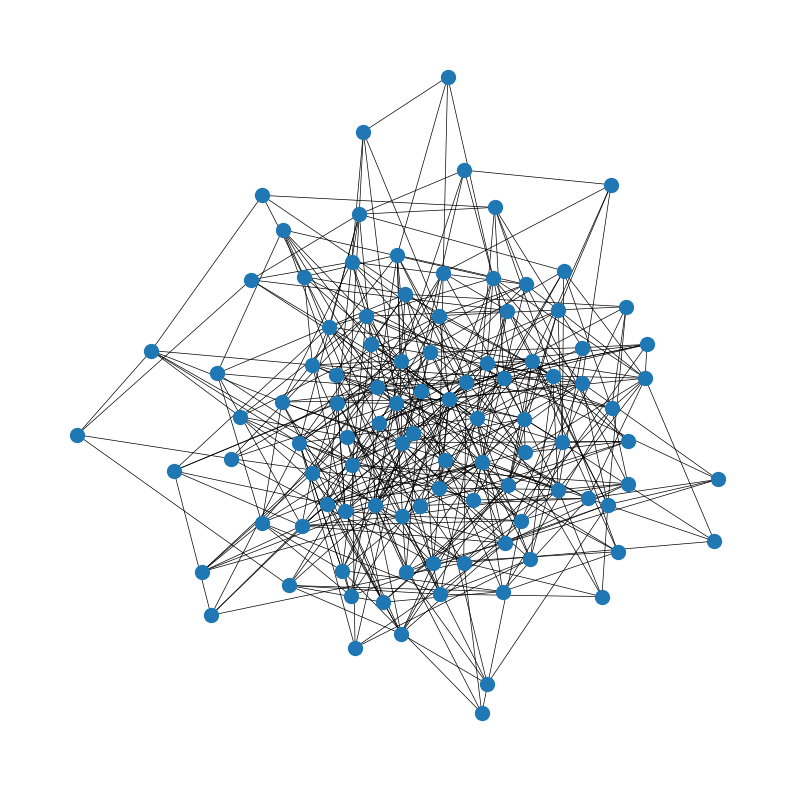

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
er_network = nx.from_numpy_matrix(er_matrix)
nx.draw(er_network, ax = ax, node_size=100, width = 0.5, edge_cmap = "Greys")


Indentify connected components of our network and filter to preserve only the largest component.

In [3]:
# Identify connected omponennts and sort them by their size

cc_generator = nx.connected_components(er_network)

[len(cc) for cc in sorted(cc_generator, key=len, reverse=True)]      # Sort connected components

# Only one large component has been identified.


[100]

### a) Random walk
Start in a random node and, at each time step, randomly move to one of its neighbors. Record the
position of the walker after 𝑡timesteps, with 𝑡≫𝑑 with 𝑑the diameter of the network). Repeat the simulation a
very large number of times and estimate the probability that the random walker is found in each particular node
at the end of the process. Think of biological scenarios where this kind of dynamics could be relevant.

I will now define the paramenters and develop the code to simulate a random walk through the network. I will repeat the random walk simulation 100 times to obtain an average probability of finding the walker in each node.

In [4]:
# Define simulation parameters

diameter = nx.diameter(er_network)      # Get the diameter of the network
num_steps = 10*diameter                 # I stablish a number of steps 10 times larger than the network diameter.
final_nodes = []                        # Save final node of each iteration
num_repeats = 1000                      # Number of simulations


# Loop over the number of simulations
for i in range(num_repeats):
    
    # Choose a random starting node
    curr_node = np.random.choice(list(er_network.nodes()))
    
    # Loop over the time steps
    for j in range(num_steps):
        
        # Get the neighbors of the current node
        neighbors = list(nx.neighbors(G = er_network, n = curr_node))
        
        # Choose a random neighbor for the walker to move to
        next_node = np.random.choice(neighbors)
        
        # Update the current node
        curr_node = next_node

    final_nodes.append(curr_node)

Text(0.5, 0, 'Final nodes')

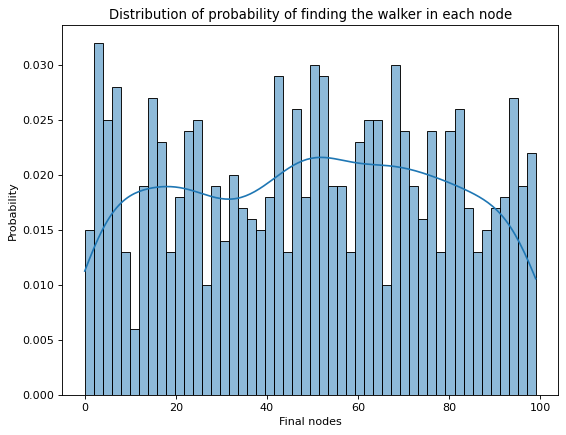

In [5]:
import pandas as pd
import seaborn as sns

plt.figure(dpi = 80, figsize=(8,6))
sns.histplot(data = final_nodes, bins = 50, kde = True, stat = "probability")
plt.title("Distribution of probability of finding the walker in each node")
plt.xlabel("Final nodes")

The distribution I obtained is quite heterogeneous, some nodes have a relatively higher possibility (over 0.03) to result the final position of the walker, while some in some other nodes the probability drops below 0.01, more than 3-fold reduction.

In a biological context, this behaviour could be observed in network-like systems where some nodes contribute in a larger extent to the function of the whole complex. For instance, in signalling pathways, some kinases (MAPK, G-Proteins, etc.) have a central role in multiple downstream pathways, while others are rather specialised in certain molecular processes. Therefore, when we analyse the mechanisms involved in the response to stimuli, the "more important" nodes will be active with a higher probability than the less central ones.

### b) Spreading of an infection across towns
Spreading of an infection across towns : assume that each node represents a town and edges represent mobility patterns across towns. Start with a single town infected at very low prevalence. At each time step, the prevalence in each town increases by 1% (i.e., it is multiplied by 1.01). Moreover, the infection spreads to all neighboring towns at a rate that is proportional to the prevalence in the town of origin multiplied by a mobility factor m (set m = 1 for simplicity). Simulate the process until the infection has reached appreciable prevalence in all towns (e.g. 10 4 times the prevalence of the initial state). Compare the relative prevalence across towns.

First we will generate a 1D array that contains the infection prevalence of each town. Each node is considered a town and the edges between them represent mobility patters.

In [6]:
# Initial prevalence
prevalence = np.zeros(nodes)
init_infection = [np.random.randint(0, nodes)]
prevalence[init_infection] = 0.01                      
init_prevalence = sum(prevalence)
movility = 1

print(prevalence)
print("Initial prevalence:", init_prevalence)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]
Initial prevalence: 0.01


Next, I will perform an iterative step to simulate the spread of the infection from infected towns to neighboring nodes, based on the following considerations:
- An uninfected town can only be infected by an already infected neighbor town.
- In every time step, already infected towns increase their prevalence by 1% due to intra-node spread
- Infection is spread between nodes at a rate that is proportional to the prevalence in the town of origin multiplied by the mobility factor.

In [7]:
while sum(prevalence) < init_prevalence*10000:          # Process is repeated intial prevalence ot the total network increases 10,000 times.
    for town in range(nodes):
        neighbors = list(nx.neighbors(G = er_network, n = town))
        for neighbor in neighbors:
            if prevalence[neighbor] == 0:
                prevalence[neighbor] = 0.01            # New infected towns
            else:
                prevalence[neighbor] = prevalence[neighbor]*1.01 + prevalence[town] * movility          # Prevalence increase in previously infected towns

prevalence

array([ 4.86585219, 25.02185647, 14.68877368,  3.64290183, 28.74726637,
       40.27558396, 11.33955754, 16.22559836,  1.37591199, 17.87520538,
        5.0010546 , 40.25235001, 23.82604603,  5.78576089,  1.21798981,
       17.10426096,  9.75842499, 44.99491913,  3.59789195, 11.48380156,
        7.66529409, 16.89611037,  4.74094075, 58.20927129,  7.21657608,
       24.06628521, 11.6406998 ,  6.58433001, 45.69329366,  7.11948454,
       26.43551674,  6.91709197, 29.66714192, 28.28881007, 25.93734995,
        6.38370038, 15.73548298, 17.67721999,  5.26124836,  0.93966673,
       25.28017331,  4.99663202, 18.60527435,  5.7473994 , 43.13281668,
       10.57361376, 17.36882721, 13.09933511,  2.04782821,  3.99301319,
        5.29131475, 21.69080334, 11.12377602, 16.15260395, 38.38436015,
       15.14106394, 19.04034627, 36.69723985, 24.1420749 , 20.60511803,
       10.6492292 , 34.55358139,  5.68201213, 11.87047519, 12.73659988,
       13.31063857,  1.64732786,  2.58260871, 17.84033376, 12.13

Text(0, 0.5, 'Prevalence (%)')

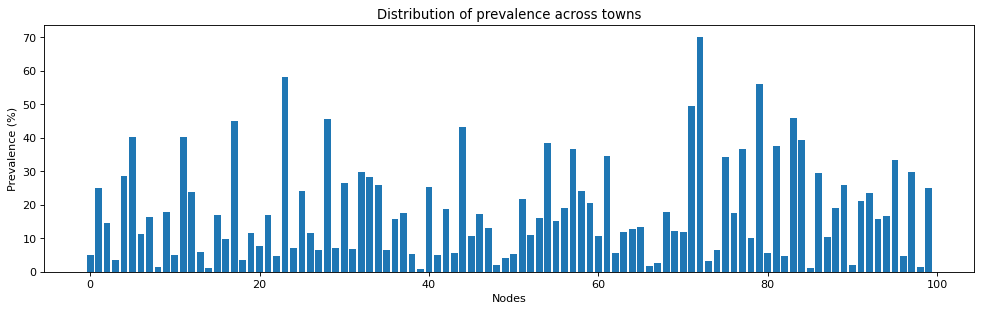

In [8]:
plt.figure(dpi = 80, figsize=(15,4))
plt.bar(x = range(nodes), height = prevalence, align="center")

plt.title("Distribution of prevalence across towns")
plt.xlabel("Nodes")
plt.ylabel("Prevalence (%)")

As we can observe, we obtained an heterogeneous distribution, in which some towns have a high prevalence (over 60%) while some others have a prevalence close to 0. This results are similar to those obtained in the distribution of probablities for each node in the random walking model.

* Which measure of network centrality (degree or eigenvector centrality) correlates the best with the distribution of probability (in the RW) or prevalence (in the disease spreading) across nodes at the end of the simulation? Are there differences between both scenarios

In [9]:
# Calculate eigenvector and degree centralities for the different nodes of each network.
eig_cent = nx.eigenvector_centrality(er_network)
deg_cent = nx.degree_centrality(er_network)

# Sort the random walker model values according to its nodes
random_walk_dict = {i:final_nodes.count(i) for i in final_nodes}
random_walk_sorted = {key:value for key, value in sorted(random_walk_dict.items(), key = lambda item: item[0])}       # Sorting algorithm: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

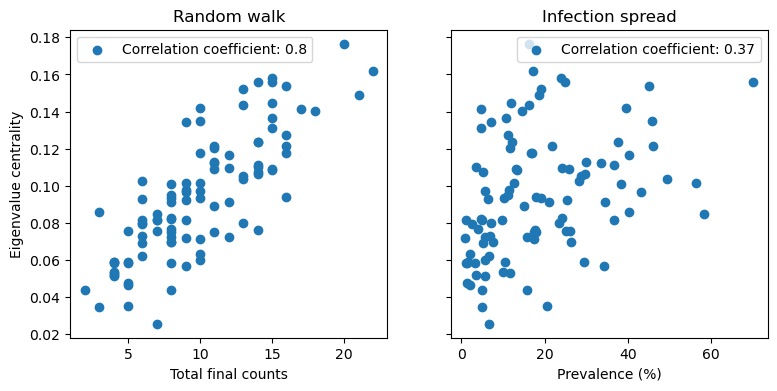

In [10]:
cor1 = np.corrcoef(list(random_walk_sorted.values()), list(eig_cent.values()))[0,1]
cor2 = np.corrcoef(prevalence, list(eig_cent.values()))[0,1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4), sharey = True)
ax1.scatter(x = list(random_walk_sorted.values()), y = list(eig_cent.values()), label = "Correlation coefficient: {}".format(round(cor1, 2)))
ax2.scatter(x = prevalence, y = list(eig_cent.values()), label = "Correlation coefficient: {}".format(round(cor2, 2)))

ax1.set_title("Random walk")
ax1.set_ylabel("Eigenvalue centrality")
ax1.set_xlabel("Total final counts")
ax2.set_title("Infection spread")
ax2.set_xlabel("Prevalence (%)")

ax1.legend()
ax2.legend()


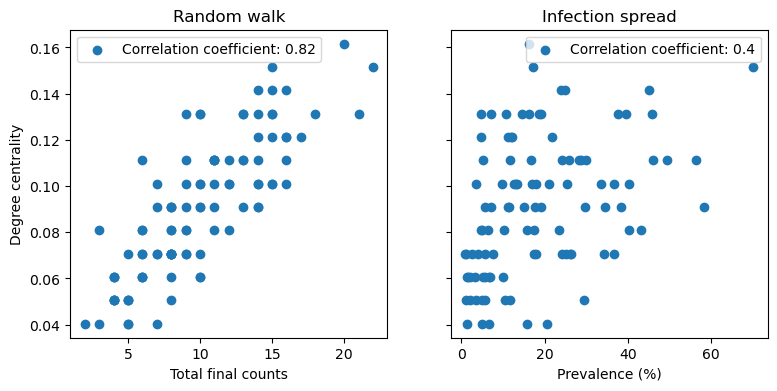

In [11]:
cor1 = np.corrcoef(list(random_walk_sorted.values()), list(deg_cent.values()))[0,1]
cor2 = np.corrcoef(prevalence, list(deg_cent.values()))[0,1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4), sharey = True)
ax1.scatter(x = list(random_walk_sorted.values()), y = list(deg_cent.values()), label = "Correlation coefficient: {}".format(round(cor1, 2)))
ax2.scatter(x = prevalence, y = list(deg_cent.values()), label = "Correlation coefficient: {}".format(round(cor2, 2)))

ax1.set_title("Random walk")
ax1.set_ylabel("Degree centrality")
ax1.set_xlabel("Total final counts")
ax2.set_title("Infection spread")
ax2.set_xlabel("Prevalence (%)")

ax1.legend()
ax2.legend()

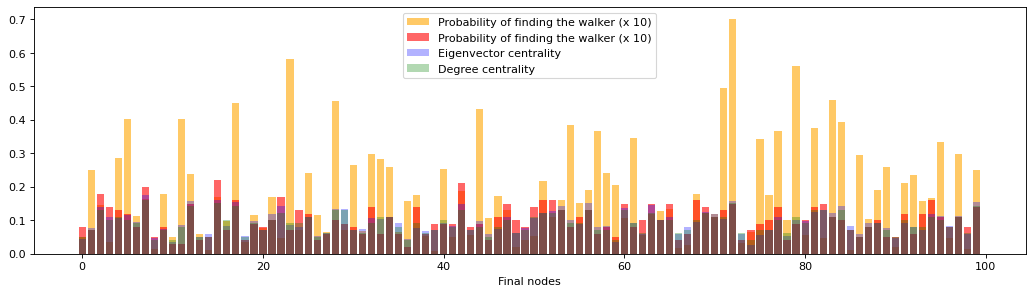

In [12]:
plt.figure(dpi = 80, figsize=(16,4))
plt.bar(x = range(nodes), height=np.divide(prevalence, 100), alpha = 0.6, color = "orange", label = "Probability of finding the walker (x 10)")
plt.bar(x = list(random_walk_dict.keys()), height=np.divide(list(random_walk_dict.values()),100), alpha = 0.6, color = "red", label = "Probability of finding the walker (x 10)")
plt.bar(x = list(eig_cent.keys()), height=list(eig_cent.values()), alpha = 0.3, color = "blue", label = "Eigenvector centrality")
plt.bar(x = list(deg_cent.keys()), height=list(deg_cent.values()), alpha = 0.3, color = "green", label = "Degree centrality")
plt.xlabel("Final nodes")
plt.legend()

Simply based on these graphs we can observe that both centrality measures correlate better with the distribution of probability (in the Random Walker) than with the prevalence in the disease spreading model. There are no significant differences in performance between both centrality measures for the random walker model are the infection spread model. However, the most notable difference between both measures can be observed in the scatter plots. We can see that the values of degree centrality are discrete rather than continous opposite to eigenvalue centrality.

* Try reducing the mobility by a factor 10 and 100 (m = 0.1, m = 0.01). Does that change the general pattern of relative prevalence across towns? What are the practical effects of reducing mobility?

I will reduce the prevalence limit at which the loop stops to reduce computation time.

Text(0, 0.5, 'Prevalence (%)')

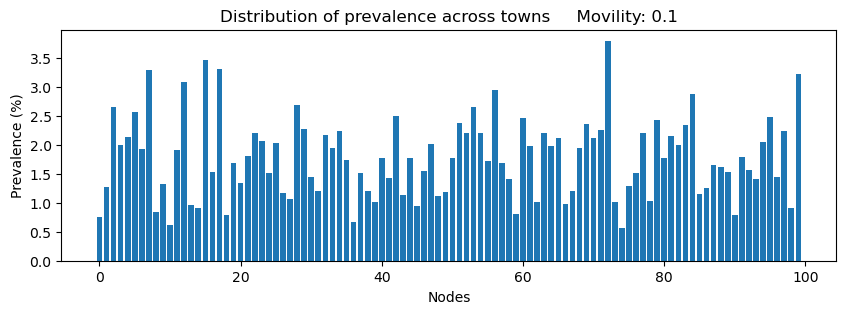

In [13]:
## Movility 0.1

prevalence = np.zeros(nodes)
init_infection = [np.random.randint(0, nodes)]
prevalence[init_infection] = 0.01
init_prevalence = sum(prevalence)

while sum(prevalence) < init_prevalence*10000:          # Process is repeated intil prevalence ot the total prevalence increases 10,000 times.
    for town in range(nodes):
        neighbors = list(nx.neighbors(G = er_network, n = town))
        for neighbor in neighbors:
            if prevalence[neighbor] == 0:
                prevalence[neighbor] = 0.01         # New infected towns
            else:
                prevalence[neighbor] = prevalence[neighbor]*1.01 + prevalence[town] * 0.1          # Prevalence increase in previously infected towns

plt.figure(figsize=(10, 3))
plt.bar(x = range(nodes), height = prevalence, align="center")
plt.title("Distribution of prevalence across towns     Movility: 0.1")
plt.xlabel("Nodes")
plt.ylabel("Prevalence (%)")

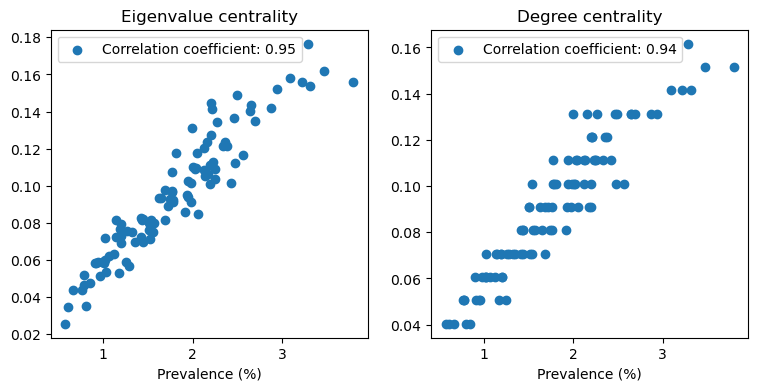

In [14]:
## Movility 0.1
cor1 = np.corrcoef(prevalence, list(eig_cent.values()))[0,1]
cor2 = np.corrcoef(prevalence, list(deg_cent.values()))[0,1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4))
ax1.scatter(x = prevalence, y = list(eig_cent.values()), label = "Correlation coefficient: {}".format(round(cor1, 2)))
ax2.scatter(x = prevalence, y = list(deg_cent.values()), label = "Correlation coefficient: {}".format(round(cor2, 2)))

ax1.set_title("Eigenvalue centrality")
ax2.set_title("Degree centrality")
ax1.set_xlabel("Prevalence (%)")
ax2.set_xlabel("Prevalence (%)")

ax1.legend()
ax2.legend()

Text(0, 0.5, 'Prevalence (%)')

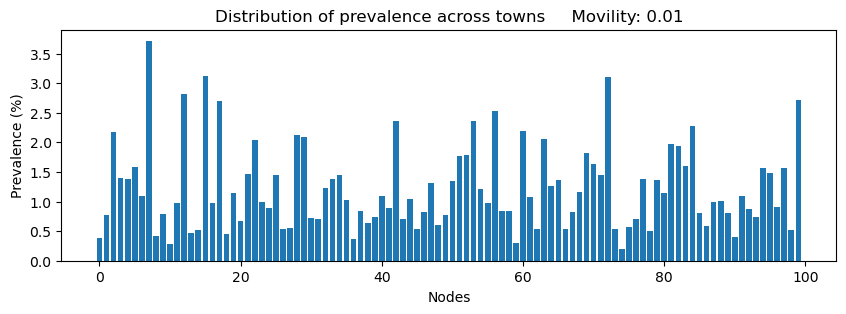

In [15]:
## Movility 0.01

prevalence = np.zeros(nodes)
init_infection = [np.random.randint(0, nodes)]
prevalence[init_infection] = 0.01
init_prevalence = sum(prevalence)

while sum(prevalence) < init_prevalence*10000:          # Process is repeated intil prevalence ot the total prevalence increases 10,000 times.
    for town in range(nodes):
        neighbors = list(nx.neighbors(G = er_network, n = town))
        for neighbor in neighbors:
            if prevalence[neighbor] == 0:
                prevalence[neighbor] = 0.01         # New infected towns
            else:
                prevalence[neighbor] = prevalence[neighbor]*1.01 + prevalence[town] * 0.01          # Prevalence increase in previously infected towns

plt.figure(figsize=(10, 3))
plt.bar(x = range(nodes), height = prevalence, align="center")
plt.title("Distribution of prevalence across towns     Movility: 0.01")
plt.xlabel("Nodes")
plt.ylabel("Prevalence (%)")

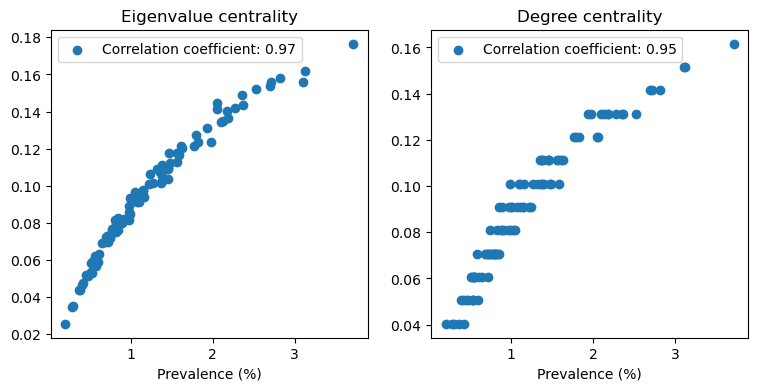

In [16]:
## Movility 0.01
cor1 = np.corrcoef(prevalence, list(eig_cent.values()))[0,1]
cor2 = np.corrcoef(prevalence, list(deg_cent.values()))[0,1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4))
ax1.scatter(x = prevalence, y = list(eig_cent.values()), label = "Correlation coefficient: {}".format(round(cor1, 2)))
ax2.scatter(x = prevalence, y = list(deg_cent.values()), label = "Correlation coefficient: {}".format(round(cor2, 2)))

ax1.set_title("Eigenvalue centrality")
ax2.set_title("Degree centrality")
ax1.set_xlabel("Prevalence (%)")
ax2.set_xlabel("Prevalence (%)")

ax1.legend()
ax2.legend()

As we can observe, the lower the movility, the more correlation exists between the centrality measures and the prevalence. Moreover, the average prevalence in all towns is also reduced.

# Exercise 5.2 - The effects of heterogeneity in the number of contacts

Carry out a numerical simulation of a rumor propagation process that starts with a single individual carrying a hot new. At each time step, individuals can pass the rumor to their neighbors with probability 𝛽(per neighbor). With probability 𝜇, informed individuals stop propagating the rumor as it is not a hot new anymore (this would be equivalent to recovery in a SIR model). Follow the numbers of informed individuals at each time step and compare with the mean field solution. Hint: the mean field in this case corresponds to the propagation at a constant speed given by the average number of contacts.
Repeat the simulation a large number of times. Record the time at which the rumor stops propagating (if it does at all). Plot the distribution of rumor extinction times. Compare the following situations in a large population (𝑁≥1000)

* Individuals are randomly connected (Erdös Rényi network)
* Individuals are fixed in a 2D lattice
* Individuals are the nodes of a preferential attachment network.

Do the results depend on the initial individual? Can you find some general principle explaining when the rumor spreads to the whole population and when it dies out, leading to just a locally “informed” group?

In [48]:
# First we construct the networks
erdos_renyi = nx.erdos_renyi_graph(n=100, p = 0.1, seed = 3) 
small_world = nx.watts_strogatz_graph(n = 100, k = 4, p = 0.1, seed = 3)
preferential = nx.barabasi_albert_graph(n = 100, m = 1, seed = 3)

# We filter Erdos Renyi's connected components to pick only the largest component.
cc_generator = nx.connected_components(erdos_renyi)
erdos_renyi = erdos_renyi.subgraph(sorted(cc_generator, key=len, reverse=True)[0])

# Define a function for plotting the networks
def plot_network(network):
    nx.draw(network, ax = ax, node_size=20, width = 0.5, edge_cmap = "autumn")

Text(0.5, 1.0, 'Preferential Attachment Network')

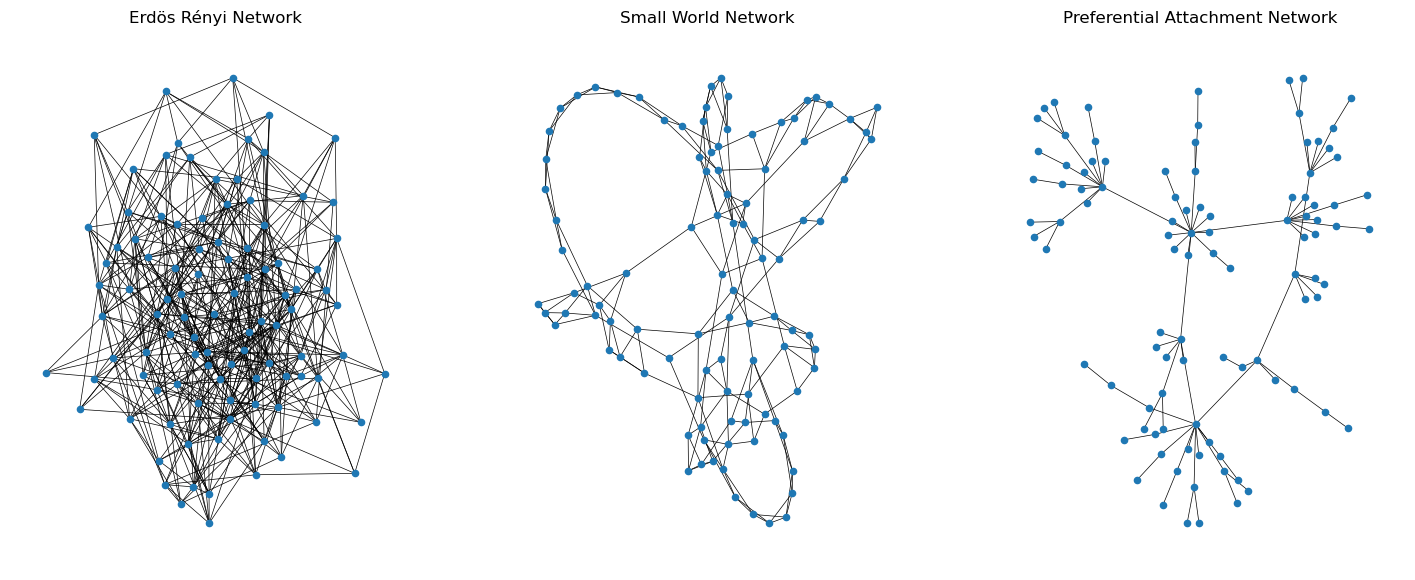

In [49]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 3, 1)
plot_network(erdos_renyi)
ax.set_title("Erdös Rényi Network")
ax = plt.subplot(1, 3, 2)
plot_network(small_world)
ax.set_title("Small World Network")
ax = plt.subplot(1, 3, 3)
plot_network(preferential)
ax.set_title("Preferential Attachment Network")

Nwxt, I will construct a function that simulates the rumour spread. Beta is the probability of rumour spread from an individual carrying a rumour to a neighbor. Mu is the probability that the rumour is not a hot topic anymore and stops being spread.

1 -> Individuals informed of the rumour

0 -> Individuals susceptible of being informed

2 -> Individuals who do not spread the rumour anymore

In [225]:
def rumour_spread(network, nodes = 100, num_steps = 100, beta = 0.3, mu = 0.2, random_state = None):
    
    np.random.seed(seed=random_state)               # Achieve reproducibility

    individuals = np.zeros(nodes)                   # Matrix containing individuals informed (1) or not informed (0)
    individuals[np.random.choice(nodes)] = 1        # Introduce the rumour
    infected_ind = individuals                      # Save initial conditions
       
    for step in range(1, num_steps):

        for node in list(network.nodes()):
            
            if individuals[node] == 1:
                
                prob_stop = np.random.uniform(0,1)              # Informed individuals stop spreading
                if prob_stop < mu:
                    individuals[node] = 2
                
                else:
                    neighbors = list(nx.neighbors(G = network, n = node))       # Susceptible individuals become informed
                    for neighbor in neighbors:
                        if individuals[neighbor] == 0:
                            prob_spread = np.random.uniform(0,1)
                            if prob_spread < beta:
                                individuals[neighbor] = 1
            
        infected_ind = np.vstack((infected_ind, individuals))                   # Append the current population to previous records.

        if sum(individuals == 1) == 0:
            break

    return infected_ind, step

In [226]:
beta = 0.4
mu = 0.1

infections_er, final_er = rumour_spread(erdos_renyi, nodes = 100, beta = beta, mu = mu, random_state=0)
infections_sw, final_sw = rumour_spread(small_world, nodes = 100, beta = beta, mu = mu, random_state=0)
infections_pr, final_pr = rumour_spread(preferential, nodes = 100, beta = beta, mu = mu, random_state=0)

Calculate the **mean field** for each network model, that is, the infection propagation at a constant speed given by the average number of contacts. To do this, first we need to calculate the average degree of the networks.


In [227]:
avg_degree_er = np.mean(list(dict(nx.degree(erdos_renyi)).values()))
avg_degree_sw = np.mean(list(dict(nx.degree(small_world)).values()))
avg_degree_pr = np.mean(list(dict(nx.degree(preferential)).values()))
#print(avg_degree_er, avg_degree_sw, avg_degree_pr)

In [228]:
# The mean propagations can be calculated multiplying the number of informed individuals by the average degree (number of neigbors) and by beta.
# Informed individuals can also stop propagating with a probability mu.
     
def mean_field(avg_degree, num_steps = 100, beta = 0.3, mu = 0.2):
    propagation = [1]
    for i in range(num_steps):
        active_inf = propagation[-1]
        new_inf = active_inf*avg_degree*beta - mu*active_inf
        propagation.append(new_inf)
    return propagation

In [229]:
mean_field_er = mean_field(avg_degree_er, beta = beta, mu = mu)
mean_field_sw = mean_field(avg_degree_sw, beta = beta, mu = mu)
mean_field_pr = mean_field(avg_degree_pr, beta = beta, mu = mu)

Now for comparison, I will plot both the mean field for each model and the actual number of informed, susceptible and recovered individuals within the network per time step.

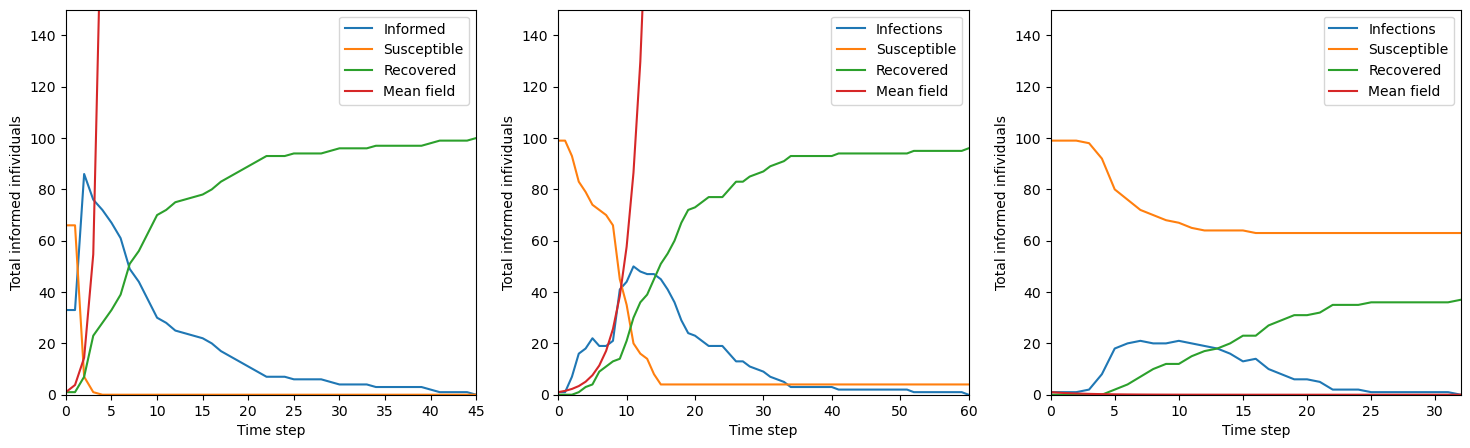

In [230]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (18, 5))

ax1.plot((infections_er == 1).sum(axis=1), label = "Informed")
ax1.plot((infections_er == 0).sum(axis=1), label = "Susceptible")
ax1.plot((infections_er == 2).sum(axis=1), label = "Recovered")
ax1.plot(mean_field_er, label = "Mean field")
ax1.set_ylim((0, 150))
ax1.set_xlim((0, final_er))
ax1.set_ylabel("Total informed infividuals")
ax1.set_xlabel("Time step")
ax1.legend()

ax2.plot((infections_sw == 1).sum(axis=1), label = "Infections")
ax2.plot((infections_sw == 0).sum(axis=1), label = "Susceptible")
ax2.plot((infections_sw == 2).sum(axis=1), label = "Recovered")
ax2.plot(mean_field_sw, label = "Mean field")
ax2.set_ylim((0, 150))
ax2.set_xlim((0, final_sw))
ax2.set_ylabel("Total informed infividuals")
ax2.set_xlabel("Time step")
ax2.legend()

ax3.plot((infections_pr == 1).sum(axis=1), label = "Infections")
ax3.plot((infections_pr == 0).sum(axis=1), label = "Susceptible")
ax3.plot((infections_pr == 2).sum(axis=1), label = "Recovered")
ax3.plot(mean_field_pr, label = "Mean field")
ax3.set_ylim((0, 150))
ax3.set_xlim((0, final_pr))
ax3.set_ylabel("Total informed infividuals")
ax3.set_xlabel("Time step")
ax3.legend()


Next, I will repeat the simulation 1000 times and analyse the distribution of time steps at which the rumour becomes extinct.

In [231]:
num_repeats = 1000

beta = 0.6
mu = 0.1

final_steps_er = []
final_steps_sw = []
final_steps_pr = []

for i in range(num_repeats):
    infections_er, final_er = rumour_spread(erdos_renyi, nodes = 100, beta = beta, mu = mu)
    infections_sw, final_sw = rumour_spread(small_world, nodes = 100, beta = beta, mu = mu)
    infections_pr, final_pr = rumour_spread(preferential, nodes = 100, beta = beta, mu = mu)
    final_steps_er.append(final_er)
    final_steps_sw.append(final_sw)
    final_steps_pr.append(final_pr)


Text(0.5, 0, 'Time step')

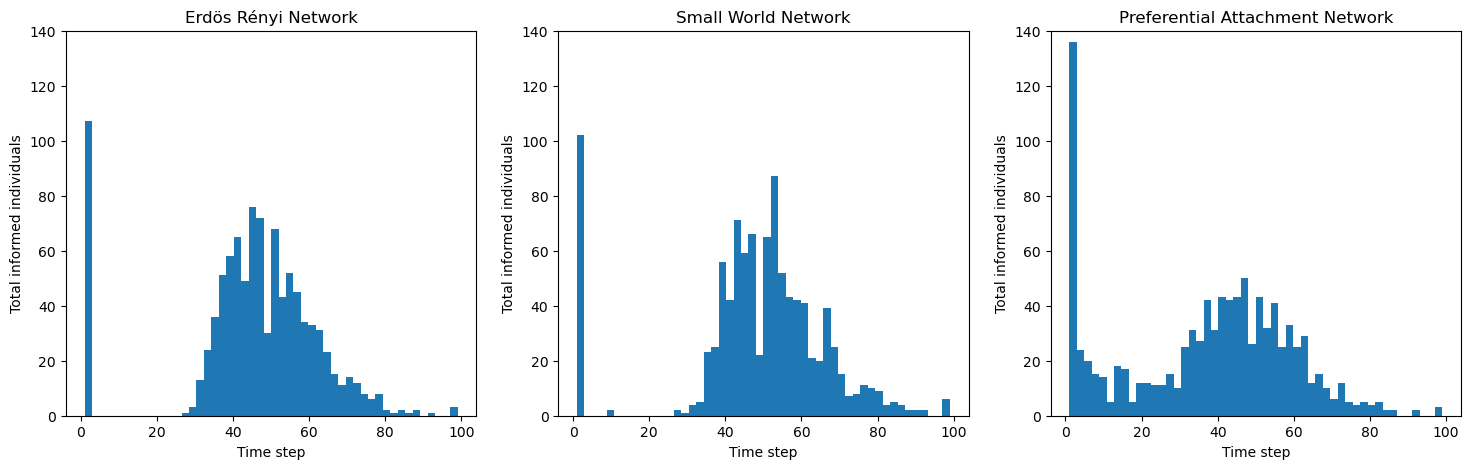

In [238]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (18, 5))

ax1.hist(final_steps_er, bins = 50)
ax1.set_ylim((0, 140))
ax1.set_title("Erdös Rényi Network")
ax1.set_ylabel("Total informed individuals")
ax1.set_xlabel("Time step")

ax2.hist(final_steps_sw, bins = 50)
ax2.set_ylim((0, 140))
ax2.set_title("Small World Network")
ax2.set_ylabel("Total informed individuals")
ax2.set_xlabel("Time step")

ax3.hist(final_steps_pr, bins = 50)
ax3.set_ylim((0, 140))
ax3.set_title("Preferential Attachment Network")

ax3.set_ylabel("Total informed individuals")
ax3.set_xlabel("Time step")


We can see that the distribution of final time steps at which the rumour spread stops is similar in the three models. In all models, a large number of simulation repeats (N > 100) end up with the rumour death at time step t=1, and a in the mayority of cases, rumour stops spreading between time steps t=30 and t=70.

However, there are significant differences regarding rumour extinction at short time periods. We cannot observe any rumour extinction records at time steps t<20 at the Erdös Rényi network and just a few short-term extinction events can be observed in Small World models. In contrast, a rather large amount of rumour extinction events occur at short time steps in the Preferential Attachment Network.

In [247]:
print("Mean Degree:\nErdös Rényi =",avg_degree_er, "\nSmall World =", avg_degree_sw, "\nPreferential Attachment =", avg_degree_pr)

Mean Degree:
Erdös Rényi = 9.74 
Small World = 4.0 
Preferential Attachment = 1.98


We can observe a clear relationship between the average degree of each network and the number of rumour extiction events occuring at shot times (t<20). This way, highly connected networks (Erdös-Rényi) will likely lead to an homogeneous spread of the rumour over all the individuals of the network, and therefore, rumour takes longer time to become extinct.

In contrast, networks with a lower node connectivity (Preferential Attachment) are more likely to report early rumour extinction and to produce small clusters of locally informed individuals while the vast mayority of the population remains uninformed, as in the example simulation plotted above.

Of course, this depends on the initial informed individual. If the initial individual is located in a central well-connected position within the network, the rumour will efficiently spread to all or the mayority of individuals, whereas if the initial individual is located on peripheral or low-connected nodes, the rumour spread will experience a rapid decay.